In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from my_xgboost import XGBoost

# 加载数据集
data = load_diabetes()
X, y = data.data, data.target
feature_names = data.feature_names

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 结果收集字典
results = {}

def evaluate_model(y_true, y_pred):
    return {
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

# =====================
# 1. XGBoost
# =====================
start_time = time.time()
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
xgb_model.fit(X_train, y_train)
train_time = time.time() - start_time

results['XGBoost'] = evaluate_model(y_test, xgb_model.predict(X_test))
results['XGBoost']['Time'] = train_time

# =====================
# 2. Scikit-learn
# =====================
start_time = time.time()
sk_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
sk_model.fit(X_train, y_train)
train_time = time.time() - start_time

results['Sklearn'] = evaluate_model(y_test, sk_model.predict(X_test))
results['Sklearn']['Time'] = train_time

# =====================
# 3. H2O
# =====================
h2o.init()
train_h2o = h2o.H2OFrame(np.column_stack((X_train, y_train)), 
                       column_names=list(feature_names)+['target'])
test_h2o = h2o.H2OFrame(np.column_stack((X_test, y_test)), 
                      column_names=list(feature_names)+['target'])

start_time = time.time()
h2o_model = H2OGradientBoostingEstimator(
    ntrees=100,
    learn_rate=0.1,
    max_depth=3,
    seed=42,
    distribution="gaussian"
)
h2o_model.train(x=feature_names, y="target", training_frame=train_h2o)
train_time = time.time() - start_time

results['H2O'] = evaluate_model(y_test, h2o_model.predict(test_h2o).as_data_frame()['predict'].values)
results['H2O']['Time'] = train_time
h2o.cluster().shutdown()

# =====================
# 4. My XGBoost
# =====================
start_time = time.time()
my_model = XGBoost(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)
my_model.fit(X_train, y_train)
train_time = time.time() - start_time

y_pred = my_model.predict(X_test)
results['My XGBoost'] = evaluate_model(y_test, y_pred)
results['My XGBoost']['Time'] = train_time

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM JBR-21.0.6+9-895.97-nomod (build 21.0.6+9-b895.97, mixed mode, sharing)
  Starting server from C:\Users\Sink\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Sink\AppData\Local\Temp\tmpoo68xrwd
  JVM stdout: C:\Users\Sink\AppData\Local\Temp\tmpoo68xrwd\h2o_钱江雷_started_from_python.out
  JVM stderr: C:\Users\Sink\AppData\Local\Temp\tmpoo68xrwd\h2o_钱江雷_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Hong_Kong
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,5 months and 11 days
H2O_cluster_name:,H2O_from_python_钱江雷_ip9h1p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.823 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

c:\Users\Sink\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
H2O session _sid_8c32 closed.


Training XGBoost: 100%|██████████████| 100/100 [elapsed: 00:02 remaining: 00:00]


<Figure size 2400x500 with 0 Axes>

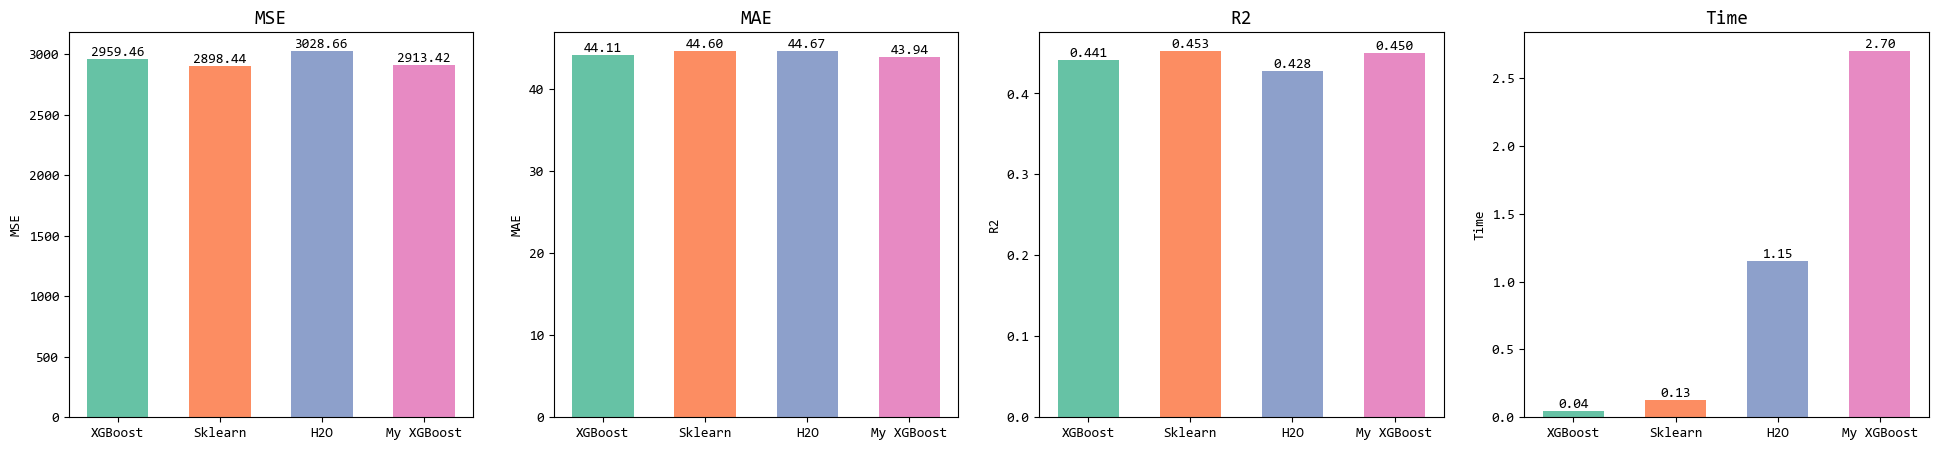

In [3]:
# =====================
# 可视化
# =====================
plt.rcParams['font.sans-serif'] = ['Consolas']
plt.figure(figsize=(24, 5))
models = list(results.keys())
metrics = ['MSE', 'MAE', 'R2', 'Time']
titles = ['MSE', 'MAE', 'R2', 'Time']
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

fig, axs = plt.subplots(1, 4, figsize=(24, 5))

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axs[idx]
    x = range(len(models))
    values = [results[model].get(metric, 0) for model in models]
    
    bars = ax.bar(x, values, color=colors, width=0.6)
    
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel(metric)
    
    for bar in bars:
        height = bar.get_height()
        va = 'bottom' if height > 0 else 'top'
        if metric == 'R2':
            text = f'{height:.3f}'
        else:
            text = f'{height:.2f}'
        ax.text(bar.get_x() + bar.get_width()/2., height, text,
                ha='center', va=va, fontsize=10)

plt.subplots_adjust(wspace=0.2)
plt.show()